<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Improving Online Advertising via Classification
###  Author: Kyle Ness, Online Analysis Co.

## Problem Statement

If a company wants to be successful in marketing their products to prospective customers, they must know their audience. The founders at Everything Meal Prep believe that wholeheartedly, and for that reason, they have gone the distance of hiring us consultants at Online Analysis Co. to help them towards this success. They have done this in the hopes that via our data-driven insights and our ability to create an automated classification system, their meal plan advertisements will only reach customers with matching diets / food interests going forward. This should save them money that would otherwise be spent on ineffective advertising, and conversely, potentially boost sales (if they committed to the same amount of advertising spend). 

Specifically, Everything Meal Prep has tasked us with improving their online advertisements hosted on reddit. As their name suggests, they provide customers meal plans consisting of virtually any ingredients. For this task, they want us to focus solely on aiding the performance of their carnivore and vegan meal plan lines. To this end, we must build an accurate binary classification system, determining whether an online person is a carnivore or a vegan. We will do this by analyzing data that we scraped from the subreddits (of Reddit.com) r/vegan and r/carnivore. Hopefully by using natural language processing techniques and testing various classification models, we will arrive at a system that can perfrom this task with the utmost accuracy.

Specifically, Naive Bayes and logistic regression models will be constructed and evaluated for this task. We also aim to provide Everything Meal Prep with recommendations about how to go about their marketing.

### Contents:
- [Data Import, Cleaning, and Pre-processing](#Data-Import,-Cleaning,-and-Pre-processing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Model Creation and Evaluation](#Model-Creation-and-Evaluation)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

In [92]:
#Imports
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize          
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Error message handling
import warnings
warnings.filterwarnings('ignore') 

---
## Data Import, Cleaning, and Pre-processing

First, reading in the datasets that were scraped from each subreddit:

In [93]:
#Reading in the datasets that were scraped:
vegan = pd.read_csv('../datasets/vegan.csv')
carn = pd.read_csv('../datasets/carnivore.csv')
#We can combine these into one dataset for easier reference
data = pd.concat([vegan, carn], axis = 0)
data.reset_index(drop = True, inplace = True)

Some cleaning was already done in the 'scraping' file also located in this repository, like simple calls of drop_duplicates(). However, we will check again to see if there are any duplicates, missing values, or entries that are not worthwhile in general.

In [94]:
data['title'].value_counts().sort_values(ascending = False).head(10)

A loved one asks you to pick up a non-vegan item on the way home. What is your answer?    5
Calories                                                                                  3
Do you swat flies?                                                                        2
Which Vegan Ad Is Best?                                                                   2
I need some help                                                                          2
3 months in, would appreciate some advice/opinions                                        2
Would you eat lab-grown meat/fish?                                                        1
Vegans who feed their cats meat: Do you also give your kitties meat-based treats ?        1
I am sad and beyond disgusted...                                                          1
Cadets and Rations                                                                        1
Name: title, dtype: int64

In [95]:
data[data['title'] == 'A loved one asks you to pick up a non-vegan item on the way home. What is your answer?']['selftext'] #Only 5 rows, so all will print

323    \n\n[View Poll](https://www.reddit.com/poll/ve...
324    \n\n[View Poll](https://www.reddit.com/poll/ve...
325    \n\n[View Poll](https://www.reddit.com/poll/ve...
326    \n\n[View Poll](https://www.reddit.com/poll/ve...
327    \n\n[View Poll](https://www.reddit.com/poll/ve...
Name: selftext, dtype: object

In [96]:
data[data['title'] == 'Calories']['selftext'].head()

863     Hello! I felt my absolute best when I went veg...
1781    Hey ya’ll how can you get 4-5k calories a day ...
2004    I started carnivore today and was shocked when...
Name: selftext, dtype: object

In [97]:
data[data['title'] == 'Do you swat flies?']['selftext'].head()

992     \n\n[View Poll](https://www.reddit.com/poll/uy...
1018    [removed]\n\n[View Poll](https://www.reddit.co...
Name: selftext, dtype: object

In [98]:
vegan[vegan['title'] == 'Which Vegan Ad Is Best?']['selftext'].head() 

58     I'm doing a project for a photography course....
59    I'm doing a project for a photography course. ...
Name: selftext, dtype: object

In [99]:
data[data['title'] == 'I need some help']['selftext'].head() 

215     My wife (32f) came to me about 5 years ago and...
1049    Hello everyone :) I’m learning about how eatin...
Name: selftext, dtype: object

In [100]:
data[data['title'] == '3 months in, would appreciate some advice/opinions']['selftext'].head() 

1150    I’m 2 days away from 3 months of very strict c...
1151    I’m 2 days away from 3 months of very strict c...
Name: selftext, dtype: object

Here, "A loved one asks..." and "Do you swat flies?" do not offer us very worthwhile descriptions, as they only contain polls. These should be dropped. Additionally, the posts titled "Which Vegan Ad Is Best?" and "3 months in..." seem to be duplicates / reposts that were not picked up by drop_duplicates when scraping. We will have to drop these manually. The post titles "Calories" and "I need some help" are also repeated, but given that their associated descriptions are unique, these seem to incidences of genuine re-use. That is, perhaps these titles are common. These will be kept.

In [101]:
#Dropping duplicates / bad posts
data.drop(data.index[[323, 324, 325, 326, 327, 992, 1018, 58, 1150]], inplace = True)

data['title'].value_counts().sort_values(ascending = False) #Much better!

Calories                                                                                 3
I need some help                                                                         2
Packed Lunch                                                                             1
I don't understand how people buy into milk propaganda                                   1
The vegan movement as a problem                                                          1
                                                                                        ..
Two questions for a noobie...probably know the answer but checkin.                       1
Sometimes I wish meat came in pellets so you could just swallow a handful when needed    1
Trying to come away from plastic bottled water                                           1
Sunburn?                                                                                 1
Huntington's Disease advice on carnivore?                                                1

Now we will reset the indices on the dataframe once more so that there's no possible issues later due to these changes (say if we need to locate by index):

In [41]:
data.reset_index(drop = True, inplace = True)

print(data.shape)

(2091, 3)


We lost more r/vegan observations than those of the r/carnivore, but not a very significant difference between the two. This should be fine going forward to classification, as the classes are virtually still perfectly balanced. Now we must move into pre-processing our texts so that we can get the most out of our classifiers. 

In [42]:
data['selftext'][0]

" I really want to stop being complacent and ignoring the fact that I'm constantly going against what I think is right ( Ex. Eating tortured animals and their products, food that has been processed beyond recognition in pollutive factories and produce that has been shipped across the world and farmed essentially by slaves). I have no idea where to start and I'm super intimidated by the idea of really taking responsibility to do the right thing. I'm lazy and I know if I take on too much at once, I'll abandon ship and go back to trying not to think about the bad I'm doing. \n\nAny tips on how to get started and stay on track? I wish I could just photosynthesize."

In [43]:
data['selftext'][1]

"Hypothyroidism and plant-based diet-your thoughts?  \n Does anyone suffer with Hypothyroidism? Do you feel your plant-based diet can help with this?  \nI'd love to hear other people's thoughts because I recently got diagnosed!  I came across this video and wondering if there's a link  \n[https://www.youtube.com/watch?v=mpfxbVPUAYI](https://www.youtube.com/watch?v=mpfxbVPUAYI)"

In [44]:
data['selftext'][2]

"I bought myself some of the gardein Buffalo wings as a splurge. And holy moly these things are ridiculously spicy!!!! I can handle a lot of spice, I love spicy food and growing up my dad was way too generous with spicing food. but this has my tongue completely numb after just a few bites. They taste great but I'm practically about to be sick from how horribly spicy these are. Has anyone else tried these and thought the same?? Like I said I don't feel like I'm being weak here, these are just way too hot to eat."

In [45]:
data['selftext'][3]

"As the largest community of vegans on the internet we need to make sure that we are advocating for veganism as affectively as possible, and I think discourse in this movement as a whole needs improvement.\n\nI see many people in this sub are quite frustrated and angry at people who still eat meat and while these feelings are 100% valid it's important to remember that affective vegan advocacy comes from a place of empathy and understanding. We can't let these negative feelings transate into how we communicate this ideology to people. \n\nThis disgust at how animals are treated on farms can make people feel judged or shamed for supporting it. As soon as people feel judged their defence mechanism will kick in and we will loose them.\n\nWe need to remember the perspective of someone who eats meat in order to successfully advocate for the vegan lifestyle. What we are advocating for is not just a dietary change but a complete change in how humans relate to other animals and nature on this p

As can be seen in the print outs above, one of the few remaining glaring issue seems to be the representation of new-line spaces as '\n' or doubles new-line spaces as '\n\n'. This may affect word counts when going forward with NLP methods, potentially leading to inaccuracy in our models, so it would be beneficial to remove these from the dataframes using regular expressions, as we will below. By doing so, the dimensionality (and thus, complexity) of our count vectorized dataframes will be reduced.

In [46]:
#Removing any occurrences of single or double new-line characters, replacing them with just a space:
data['selftext'] = data['selftext'].str.replace('\\n|\\n\\n', ' ', regex = True)

data[data['selftext'].str.contains('\\n|\\n\\n')].shape

(0, 3)

In [47]:
data['selftext'][0]

" I really want to stop being complacent and ignoring the fact that I'm constantly going against what I think is right ( Ex. Eating tortured animals and their products, food that has been processed beyond recognition in pollutive factories and produce that has been shipped across the world and farmed essentially by slaves). I have no idea where to start and I'm super intimidated by the idea of really taking responsibility to do the right thing. I'm lazy and I know if I take on too much at once, I'll abandon ship and go back to trying not to think about the bad I'm doing.   Any tips on how to get started and stay on track? I wish I could just photosynthesize."

In [48]:
data['selftext'][1] #Notice there are no longer instances of '\n\n'

"Hypothyroidism and plant-based diet-your thoughts?    Does anyone suffer with Hypothyroidism? Do you feel your plant-based diet can help with this?   I'd love to hear other people's thoughts because I recently got diagnosed!  I came across this video and wondering if there's a link   [https://www.youtube.com/watch?v=mpfxbVPUAYI](https://www.youtube.com/watch?v=mpfxbVPUAYI)"

Now we will also remove hyperlinks using regex. Here are some examples of posts containing hyperlinks:

In [49]:
data[data['selftext'].str.contains('https:\/\/')].iloc[0]['selftext']

"Hypothyroidism and plant-based diet-your thoughts?    Does anyone suffer with Hypothyroidism? Do you feel your plant-based diet can help with this?   I'd love to hear other people's thoughts because I recently got diagnosed!  I came across this video and wondering if there's a link   [https://www.youtube.com/watch?v=mpfxbVPUAYI](https://www.youtube.com/watch?v=mpfxbVPUAYI)"

In [50]:
data[data['selftext'].str.contains('https:\/\/')].iloc[1]['selftext']

'  [View Poll](https://www.reddit.com/poll/vm1zku)'

In [51]:
data[data['selftext'].str.contains('https:\/\/')].iloc[2]['selftext']

'I recently watched a YouTuber called Bernadette Banner who wears a lot of historic-type clothes.  She did a video awhile ago about sustainability of fashion and brought up animal product clothes.  I was curious about the thoughts of others in the vegan community.  https://youtu.be/6HXhW6nTCuo is the video in question and she starts on this topic at about 11:25 into the video.'

In [52]:
data[data['selftext'].str.contains('https:\/\/')].iloc[3]['selftext'] #This one is massive and littered with links!

' 479 million goats/year [1](https://ourworldindata.org/meat-production)🌱 574 million sheep/year [1](https://ourworldindata.org/meat-production)🌱 656 million turkeys/year [1](https://ourworldindata.org/meat-production)🌱  69,000 million chickens/year [1](https://ourworldindata.org/meat-production)🌱 1,500 million pigs/year [1](https://ourworldindata.org/meat-production)🌱 302 million cows/year [1](https://ourworldindata.org/meat-production)🌱 at least 900,000 million fish/year [2](http://fishcount.org.uk/published/std/fishcountstudy.pdf)🌱 at least 300,000 whales and dolphins in fishing bycatch/year [3](https://www.fishforward.eu/en/project/by-catch/)🌱 250,000 endangered turtles in fishing bycatch/year [3](https://www.fishforward.eu/en/project/by-catch/)🌱 salmon farms pass diseases to wild fish populations [4](http://www.eurocbc.org/Effects%20of%20Aquaculture%20on%20World%20Fish%20Supplies.htm)🌱 carnivorous fish farms require even more wild fish feed [5](https://cdnsciencepub.com/doi/full/1

In [53]:
#There are this many posts with hyperlinks scattered throughout their descriptions in the dataframe.
data[data['selftext'].str.contains('https:\/\/')].shape

(225, 3)

From these examples, it is clear that not only may some posts have several hyperlinks, but some posts are solely polls and we should remove those next. First, the hyperlinks:

In [54]:
#Removal of hyperlinks by regular expression - 
#Source on this very good regular expression for referencing hyperlinks: https://stackoverflow.com/questions/21932615/regular-expression-for-remove-link
data['selftext'] = data['selftext'].str.replace('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)', ' ', regex = True)

data[data['selftext'].str.contains('https:\/\/')].shape

(1, 3)

Seems there is one remaining stubborn post with hyperlinks still, but it should not matter. This was very good reduction. Next we will also remove instances of polls and parentheses that could be seen around the links.

In [55]:
data[data['selftext'].str.contains('\[View Poll\]|Poll')].shape

(51, 3)

In [56]:
#Removal of 'View Poll' and 'Poll' text from post desriptions - not of much use here.
data['selftext'] = data['selftext'].str.replace('\[View Poll\]|Poll', ' ', regex = True)

data[data['selftext'].str.contains('\[View Poll\]|Poll')].shape #Better!

(0, 3)

In [57]:
data[data['selftext'].str.contains('\(|\)')].shape

(799, 3)

In [58]:
#Removal of parentheses found around links and elsewhere
data['selftext'] = data['selftext'].str.replace('\(|\)', ' ', regex = True)

data[data['selftext'].str.contains('\(|\)')].shape #Better!

(0, 3)

----
## Exploratory Data Analysis

In this section, we'll create and interpret various plots showing characteristics of the dataset at hand. Let's start by creating two new features, description word count and title length. Then we shall plot their distributions.

In [59]:
#Create a column in each dataset 
data['selftext_word_count'] = data['selftext'].str.count(' ') + 1 #+1 as to count first word

In [60]:
plt.figure(figsize = (14, 8));

<Figure size 1008x576 with 0 Axes>

In [61]:
veg_word_count = data[data.subreddit == 'vegan'].selftext_word_count
carn_word_count = data[data.subreddit == 'carnivore'].selftext_word_count

Distribution for post word count for r/vegan

Median - 109.0


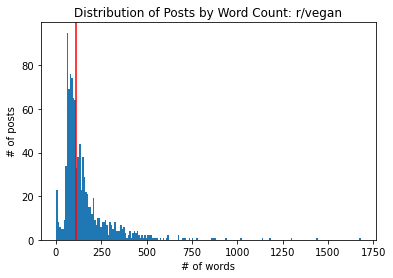

In [62]:
plt.hist(x = veg_word_count, bins = 200)
plt.xlabel('# of words')
plt.ylabel('# of posts')
plt.title('Distribution of Posts by Word Count: r/vegan')
plt.axvline(veg_word_count.median()).set(color = 'red')
print(f"Median - {veg_word_count.median()}")

Distribution for post word count for r/carnivore

Median - 57.0


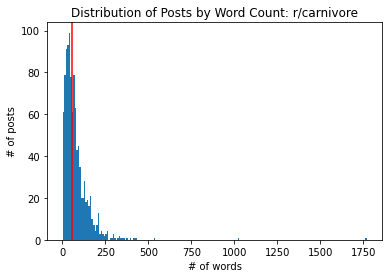

In [63]:
plt.hist(x = carn_word_count, bins = 200)
plt.xlabel('# of words')
plt.ylabel('# of posts')
plt.title('Distribution of Posts by Word Count: r/carnivore');
plt.axvline(carn_word_count.median()).set(color = 'red');
print(f"Median - {carn_word_count.median()}")

Looking at these distributions and the recorded medians, it is evident that posts on r/vegan are usually longer and that there is probably a max character count for posts (however that may be approximated with the outliers of ~1,750 words observed here). In fact, the median word count on r/vegan is almost double that of r/carnivore. This likely heavily correlates with post length if we were to investigate that feature. These are interesting notions to perhaps keep in mind for future reddit scrapes as well as when thinking about how to execute marketing of our product. r/vegan posters may be more conscientious, for example. 

Further we can look at the length of post titles:

In [64]:
data['title_length'] = data.title.str.len()
veg_len = data[data.subreddit == 'vegan'].title_length
carn_len = data[data.subreddit == 'carnivore'].title_length

Distribution for post title length for r/vegan

Median - 41.0


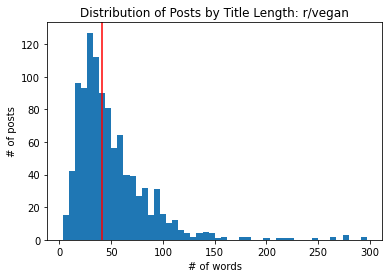

In [65]:
plt.hist(x = veg_len, bins = 50)
plt.xlabel('# of words')
plt.ylabel('# of posts')
plt.title('Distribution of Posts by Title Length: r/vegan');
plt.axvline(veg_len.median()).set(color = 'red');
print(f"Median - {veg_len.median()}")

Distribution for post title length for r/carnivore

Median - 33.0


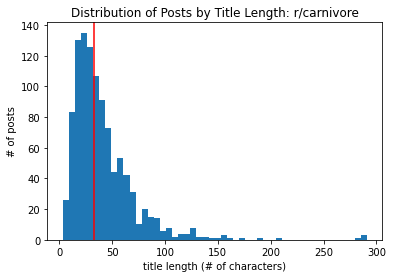

In [66]:
plt.hist(x = carn_len, bins = 50)
plt.xlabel('title length (# of characters)')
plt.ylabel('# of posts')
plt.title('Distribution of Posts by Title Length: r/carnivore');
plt.axvline(carn_len.median()).set(color = 'red');
print(f"Median - {carn_len.median()}")

Title length seems to be distributed virtually identically between the two subreddits, with r/vegan only having a slightly higher median. This doesn't really tell us much, and it is probably to be expected since titles should be brief in general.

We'll now drop the word count and title length columns added above as they will be of no use going forward.

In [67]:
data.drop(columns = ['selftext_word_count', 'title_length'], inplace = True)

data.reset_index(drop = True, inplace = True)

We will also create a new column that puts together the title and post description. This is necessary if we want to consider post titles in our models as well, because countvectorizer requires a vector (series). 

In [68]:
data['t_and_st'] = data.title + ' ' + data.selftext

Let's now look at the most common words for each subreddit. This can be accomplished by filtering by subreddit first, then pushing these dataframes through a train,test split and count vectorization. We can then plot the # of occurrences of, say, the top 25 most common words on the subreddit on one bar chart.

In [69]:
#We must filter first because two train,test splits are required. We do not want any mixing of data from the two subreddits here.
r_vegan = data[data.subreddit == 'vegan']
r_carnivore = data[data.subreddit == 'carnivore']
r_carnivore.reset_index(drop = True, inplace = True) #reset index because carnivore was the latter half of the concatenated dataframe.

First, the 30 most common words of r/vegan:

In [70]:
#Performing train, test split for only vegan data. 
X = r_vegan.t_and_st
y = r_vegan.subreddit

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = y)
    
cvec_show = CountVectorizer(stop_words = 'english')

trans_veg = pd.DataFrame(cvec_show.fit_transform(X_train).todense(), 
                        columns=cvec_show.get_feature_names_out())

#Drop and then concatenate y because trans_df.subreddit was in a weird format
trans_veg.drop(columns = 'subreddit', inplace = True)
trans_veg = pd.concat([y_train, trans_veg], axis = 1)

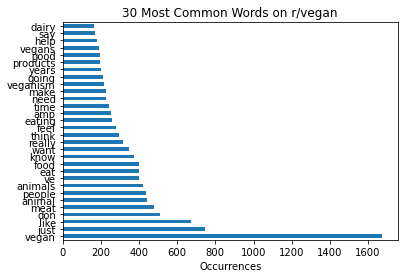

In [71]:
trans_veg.sum(numeric_only =True).sort_values(ascending=False).head(30).plot(kind='barh').set(title = '30 Most Common Words on r/vegan',
                                                                                     xlabel = 'Occurrences');

Next, the 30 most common words of r/carnivore:

In [72]:
#Performing train, test split for only carnivore data. 
X = r_carnivore.t_and_st
y = r_carnivore.subreddit

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = y)
    
cvec_show = CountVectorizer(stop_words = 'english')
                            
trans_carn = pd.DataFrame(cvec_show.fit_transform(X_train).todense(), 
                        columns=cvec_show.get_feature_names_out())

#Drop and then concatenate y because trans_df.subreddit was in a weird format
trans_carn.drop(columns = 'subreddit', inplace = True)
trans_carn = pd.concat([y_train, trans_carn], axis = 1)

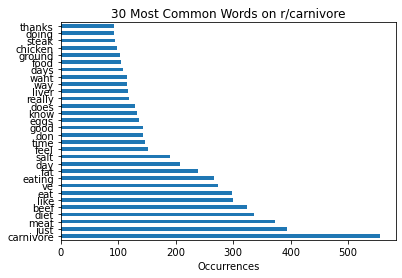

In [73]:
trans_carn.sum(numeric_only =True).sort_values(ascending=False).head(30).plot(kind='barh').set(title = '30 Most Common Words on r/carnivore',
                                                                                     xlabel = 'Occurrences');

These two plots are definitely somewhat intuitive. The 'vegan' and 'carnivore' are understandably the most common words on their respective subreddits. Further, r/vegan's common words reflect attention to animal welfare and human impact, as they actually include 'animal'and 'people' whereas r/carnivore does not. Conversely, r/carnivore seems to use words that vegans would maybe cringe hearing, like 'beef', 'eggs', 'liver', 'chicken', and 'steak'. This was surely an insightful angle to explore, especially for this analysis' purpose. When marketing our meal plans, we must make sure we advertise in a customer-friendly way, using the right words.

---
## Model Creation and Evaluation

First, we must execute our train, test split so that we can fit and later score the models we will create.

In [74]:
#Execute train, test split for whole dataframe.
X = data.t_and_st
y = data.subreddit

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = y)

Before diving into Naive Bayes and Logistic Regression models, we must acknowledge the baseline accuracy rate (that of the null model) for this data so that we know if our models are of any use. For this, we would pick the plurality class every time.

In [75]:
y_test.value_counts(normalize = True)

carnivore    0.501193
vegan        0.498807
Name: subreddit, dtype: float64

Thus, the baseline accuracy rate here is 50.12%, achieved by simply classifying every post as originating from r/carnivore (this is because r/carnivore has just barely more posts). As long as the models we are about to create offer any improvement in classification over this baseline, they can be considered useful. Now let's dive into model creation:

To start, we will create a LemmaTokenizer object that will allow a lemmatizer to be pushed through Count Vectorizer (that is, texts will be lemmatized before the dataset is transformed into a word count matrix. This should further reduce the dimensionality (and thus, complexity) of the dataset that our classification models will be fitted to. In turn, this should help performance.

In [76]:
#Create LemmaTokenizer object that will create lemmatized tokens that can be passed through a Count Vectorizer transformer.
#Source - https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer: shows how to pass a lemmatizer through CountVectorizer. 

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [77]:
#Count Vectorizer test to see ball-park figure of # of features post-transformation. This will make testing max_features values easier.

cvec_test = CountVectorizer(stop_words = 'english') #though not going the full length here, the number of features observed here should be pretty close anyway,
                                                    # just looking for a ball-park figure
trans_test = pd.DataFrame(cvec_test.fit_transform(X_train).todense(), 
                         columns=cvec_test.get_feature_names_out())
print(f'This dataframe contains {trans_test.shape[1]} features!')

This dataframe contains 11392 features!


Above, we can see that count-vectorizing our data (with just the stop_words argument), the transformed dataset has well over 10,000 features. This should be kept in mind for grid searching, as parameter 'max_features' of the cvec can be influential. Let's move forward with grid searching:

In [78]:
#Lets create two pipelines using different models, one with Naive Bayes and one with Logistic Regression. Both will use CountVectorizer.
#These pipelines make fitting easier, and grid search makes searching for the best hyperparameters simpler.
pipe_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])
pipe_log = Pipeline([
    ('cvec', CountVectorizer()),
    ('log', LogisticRegression())
])

pipe_params_nb = {
    'cvec__tokenizer': [None, LemmaTokenizer()],
    'cvec__max_features': [4_000, 5_000, 6_000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [.9,.95],
    'cvec__ngram_range': [(1, 1), (1, 2)],                 #Equivalent to fitting 72 models (then x5)
    'cvec__stop_words': ['english'],
    'cvec__strip_accents': ['unicode'],
} 

pipe_params_log = {
    'cvec__tokenizer': [None, LemmaTokenizer()],
    'cvec__max_features': [4_000, 5_000, 6_000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [.9,.95],
    'cvec__ngram_range': [(1, 1), (1, 2)],                 #Equivalent to fitting 576 models (then x5)
    'cvec__stop_words': ['english'],
    'cvec__strip_accents': ['unicode'],
    'log__penalty': ['l1', 'l2'],
    'log__max_iter': [100, 200],
    'log__C': [1.0, 0.1],
    'log__n_jobs': [-1],
}

gs_nb = GridSearchCV(pipe_nb,
                  param_grid = pipe_params_nb,
                  cv = 5)

gs_log = GridSearchCV(pipe_log,
                  param_grid = pipe_params_log,
                  cv = 5)

In [79]:
gs_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [4000, 5000, 6000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english'],
                         'cvec__strip_accents': ['unicode'],
                         'cvec__tokenizer': [None,
                                             <__main__.LemmaTokenizer object at 0x7fdf9277ad00>]})

In [80]:
gs_log.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('log', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [4000, 5000, 6000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english'],
                         'cvec__strip_accents': ['unicode'],
                         'cvec__tokenizer': [None,
                         'log__C': [1.0, 0.1], 'log__max_iter': [100, 200],
                         'log__n_jobs': [-1], 'log__penalty': ['l1', 'l2']})

In [81]:
gs_nb.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'cvec__strip_accents': 'unicode',
 'cvec__tokenizer': None}

In [82]:
#Using best parameters above, gridsearch is too time demanding.
best_nb = Pipeline([
    ('cvec', CountVectorizer(max_features = 4_000,
                            max_df = 0.9,
                            min_df = 3,
                            ngram_range = (1,2),
                            stop_words = 'english',
                            tokenizer = None,
                            strip_accents = 'unicode')),
    ('nb', MultinomialNB())
])
best_nb.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=4000, min_df=3,
                                 ngram_range=(1, 2), stop_words='english',
                                 strip_accents='unicode')),
                ('nb', MultinomialNB())])

In [83]:
gs_log.best_params_ #Seemingly no benefit to grid searching! All the default parameters of logistic regression were best

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'cvec__strip_accents': 'unicode',
 'cvec__tokenizer': None,
 'log__C': 1.0,
 'log__max_iter': 100,
 'log__n_jobs': -1,
 'log__penalty': 'l2'}

In [84]:
#Just constructing a model using best parameters above, so do not have to load gridsearch again.
best_log = Pipeline([
    ('cvec', CountVectorizer(max_features = 4_000,
                            max_df = 0.9,
                            min_df = 3,
                            ngram_range = (1,2),
                            stop_words = 'english',
                            tokenizer = None,
                            strip_accents = 'unicode')),
    ('log', LogisticRegression(n_jobs = -1))
])
best_log.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=4000, min_df=3,
                                 ngram_range=(1, 2), stop_words='english',
                                 strip_accents='unicode')),
                ('log', LogisticRegression(n_jobs=-1))])

As it turns out, lemmatizing did in fact not help model performance, at least with the estimators and parameter grids chosen here. Evaluating both models through grid search, the best params for each did not include a tokenizer. Further, the best Count Vectorizer parameters were consistent across both models: 3 min document frequency, a max features included of 4,000, and so on as seen above. Finally, the logistic regression estimator stuck with all the default values. 

Now we will plot the performance of these models with confusion matrices.

In [85]:
preds_nb = best_nb.predict(X_test)
preds_log = best_log.predict(X_test)

nb_tn, nb_fp, nb_fn, nb_tp = confusion_matrix(y_test, preds_nb).ravel()
log_tn, log_fp, log_fn, log_tp = confusion_matrix(y_test, preds_log).ravel()

Plotting confusion matrices for each model:

Text(0.5, 1.0, 'Confusion Matrix for Naive Bayes Model')

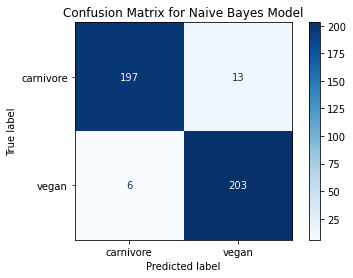

In [86]:
plot_confusion_matrix(best_nb, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Confusion Matrix for Naive Bayes Model')

Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression Model')

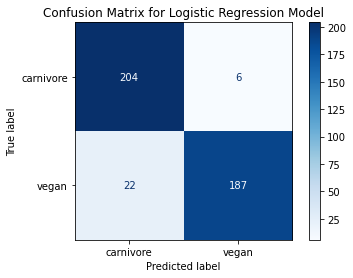

In [87]:
plot_confusion_matrix(best_log, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Confusion Matrix for Logistic Regression Model')

#### Let's bake this all down into numbers:

In [88]:
#Accuracy
print(best_nb.score(X_test, y_test))
print(best_log.score(X_test, y_test))

0.954653937947494
0.9331742243436754


In [89]:
#Specificity (true negative rates) of the models:
print(f'best_nb model specificity: {nb_tn/ (nb_tn + nb_fp)}')
print(f'best_log model specificity: {log_tn/ (log_tn + log_fp)}')

best_nb model specificity: 0.9380952380952381
best_log model specificity: 0.9714285714285714


In [90]:
#Precision
print(f'best_nb model precision: {nb_tp / (nb_tp + nb_fp)}')
print(f'best_log model precision: {log_tp/ (log_tp + log_fp)}')

best_nb model precision: 0.9398148148148148
best_log model precision: 0.9689119170984456


In [91]:
#Recall:
print(f'best_nb model precision: {nb_tp / (nb_tp + nb_fn)}')
print(f'best_log model precision: {log_tp/ (log_tp + log_fn)}')

best_nb model precision: 0.9712918660287081
best_log model precision: 0.8947368421052632


#### Summary: best_nb beats best_log in accuracy and recall. best_log beats best_nb in specificity and precision.

Given the task at hand, best_nb (Naive Bayes) is the better model. Occurrences of false positives and false negatives here are acceptable -- it would just mean that an advertisement did not land on the right person. Although some money may be wasted here, there is little harm. In fact, a few ads given to the wrong people could maybe help to woo those people to a new diet (the opposite one). 

Recall and accuracy are more important here. Recall because we would not want to classify a vegan as a carnivore given how adamant that group is about animal rights and other close topics. Accuracy because we want to target potential customers that already eat the kinds of food Everything Meal Prep are producing and advertising. They will be more likely to turn into sales for the company. Thus, we will go with the model using Naive Bayes.

## Conclusions and Recommendations

Given the results of our model creation and evaluation above, it is evident that Everything Meal Prep can indeed rely on an NLP classification system reliant on user post content for highly accurate targeting of potential customers. While the baseline accuracy rate was 50.12%, our best model, the Naive Bayes estimator paired with a CountVectorizer with tuned parameters, boasts a 95.47% accuracy rate and a 97.13% recall rate which are each very attractive for the task at hand. Everything Meal Prep should go forward with utilizing this model immediately to save on advertising spend and / or boost sales. They can know their audience like the back of their hand using this system, which is what they were initially striving for. The stakeholders in Everything Meal Prep will benefit greatly from the bolstered performance in online marketing that this system promises, as company value will increase on potential higher earnings.

Further, there are some insights gathered from the analysis here. When it comes to delivering these advertisements, they should be tailored to the nature of the recipients. As observed above, posts are generally longer on r/vegan, and seem to contain discussions of animals, people, feelings, and more that may fall outside the realm of just diets (going by common words used). These users are perhaps more conscientious, and a well-targeted ad may need to be conveyed in a savvier, more thought-provoking manner. Beyond these assumptions, the company should also simply use these common words sort of like buzzwords / points of fixation. Mentioning how Everything Meal Prep's "Super Vegan" diet helps preserve wildlife reserves, for example, may goad a vegan to try the product.

Future steps in aiding Everything Meal Prep in this endeavor would perhaps be performing more grid searches for even better hyperparamters, choosing and evaluating estimators not seen here, and collecting more data from reddit. Each of these may potentially lead to an even better-performing model than the Naive Bayes one found here.